# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import tempfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
import tensorflow_model_optimization as tfmot
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from skimage.feature import local_binary_pattern
import cv2

# Load and Prepare Data

In [2]:
image_dir = Path('../images_v2/512-resize')

In [3]:
image_dir

WindowsPath('../images_v2/512-resize')

In [4]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [5]:
# Arrange the data into images' filepaths and labellings.
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [6]:
category_samples = []
for category in images['Label'].unique():
    category_slice = images.loc[images['Label'] == category]
    category_samples.append(category_slice)
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [7]:
image_df['Label'].value_counts()

popiah            300
asam_laksa        300
nasi_lemak        300
idli              300
satay             300
putu_mayam        300
roti_canai        300
char_kway_teow    300
apam_balik        300
Name: Label, dtype: int64

# Train Test Split

In [8]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

## Create Subset 

In [9]:
num_subsets = 5  # Define the number of subsets

# Split the data into subsets for customized preprocessing
subsets_customized = []
for _ in range(num_subsets):
    subset_data, subset_labels = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
    subsets_customized.append((subset_data, subset_labels))

# Split the data into subsets for MobileNetV3 preprocessing
subsets_pretrained = []
for _ in range(num_subsets):
    subset_data, subset_labels = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
    subsets_pretrained.append((subset_data, subset_labels))

## Data Augmentation Techniques

In [10]:
def contrast_augmentation(np_tensor):
    def random_contrast(np_tensor):
        return tf.image.random_contrast(np_tensor, 0.5, 2)
    augmented_tensor = random_contrast(np_tensor)
    return np.array(augmented_tensor)

def hue_augmentation(np_tensor):
    def random_hue(np_tensor):
        return tf.image.random_hue(np_tensor, 0.5)
    augmented_tensor = random_hue(np_tensor)
    return np.array(augmented_tensor)

def add_gaussian_noise(image):
    noise = np.random.normal(loc=0, scale=0.1, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

def extract_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def concatenate_features(image, lbp_features):
    return np.concatenate((image, lbp_features))

# Define the feature engineering functions for the preprocessing_function argument
def preprocessing_function(image):
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    
    image = add_gaussian_noise(image)
    image = contrast_augmentation(image)
    image = hue_augmentation(image)
    image = image / 255.0  # Feature scaling
    lbp_features = extract_lbp_features(image)
    image = concatenate_features(image, lbp_features)
    return image

## Create Train Generators for Each Subsets

In [11]:
# Create an instance of the ImageDataGenerator for customized preprocessing
train_generators_customized = []
val_generators_customized = []

for i in range(num_subsets):
    train_generator = ImageDataGenerator(
        brightness_range=[0.2, 1.0],
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=45,
        zoom_range=[0.8, 1.25],
        channel_shift_range=0.2,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2  # Split 20% of data for validation
    )
    
    train_images = train_generator.flow_from_dataframe(
        dataframe=subsets_customized[i][0],
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        batch_size=16,
        shuffle=True,
        seed=42,
        subset='training',
        preprocessing_function=preprocessing_function
    )
    
    val_images = train_generator.flow_from_dataframe(
        dataframe=subsets_customized[i][0],
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        seed=42,
        subset='validation',
        preprocessing_function=preprocessing_function
    )
    
    train_generators_customized.append(train_images)
    val_generators_customized.append(val_images)

# Create an instance of the ImageDataGenerator for MobileNetV3 preprocessing
train_generators_pretrained = []
val_generators_pretrained = []

for i in range(num_subsets):
    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
        validation_split=0.2  # Split 20% of data for validation
    )
    
    train_images = train_generator.flow_from_dataframe(
        dataframe=subsets_pretrained[i][0],
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        batch_size=16,
        shuffle=True,
        seed=42,
        subset='training'
    )
    
    val_images = train_generator.flow_from_dataframe(
        dataframe=subsets_pretrained[i][0],
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        seed=42,
        subset='validation'
    )
    
    train_generators_pretrained.append(train_images)
    val_generators_pretrained.append(val_images)


Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filenames belonging to 9 classes.
Found 377 validated image filenames belonging to 9 classes.
Found 1512 validated image filen

## Create Test Images

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Test generator with rescaling only
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 811 validated image filenames belonging to 9 classes.


# Customized Model

In [13]:
def _hard_swish(x):
    return layers.Multiply()([layers.ReLU(6.0)(x + 3.0) / 6.0, x])

def _bottleneck(x, filters, expansion, stride, use_se=True, activation="relu"):
    input_channels = x.shape[-1]
    shortcut = x

    # Expansion phase
    x = layers.Conv2D(expansion * input_channels, kernel_size=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Squeeze and Excitation (SE)
    if use_se:
        squeeze = layers.GlobalAveragePooling2D()(x)
        excitation = layers.Dense(units=expansion * input_channels // 4, activation="relu")(squeeze)
        excitation = layers.Dense(units=expansion * input_channels, activation="hard_sigmoid")(excitation)
        excitation = layers.Reshape((1, 1, expansion * input_channels))(excitation)
        x = layers.Multiply()([x, excitation])

    # Projection phase
    x = layers.Conv2D(filters, kernel_size=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Skip connection if the input and output shapes are the same
    if stride == 1 and input_channels == filters:
        x = layers.Add()([x, shortcut])

    return x

def MobileNetV3_Custom(input_shape=(224, 224, 3), num_classes=9, width_multiplier=1.75):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Block
    x = layers.Conv2D(int(16 * width_multiplier), kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = _hard_swish(x)

    # Bottleneck Blocks
    x = _bottleneck(x, int(16 * width_multiplier), expansion=1, stride=1, use_se=True)
    x = _bottleneck(x, int(24 * width_multiplier), expansion=4, stride=2, use_se=True)
    x = _bottleneck(x, int(24 * width_multiplier), expansion=3, stride=1, use_se=True)
    x = _bottleneck(x, int(40 * width_multiplier), expansion=3, stride=2, use_se=True)
    x = _bottleneck(x, int(40 * width_multiplier), expansion=3, stride=1, use_se=True)
    x = _bottleneck(x, int(80 * width_multiplier), expansion=6, stride=2, use_se=True)
    x = _bottleneck(x, int(80 * width_multiplier), expansion=3, stride=1, use_se=True)
    x = _bottleneck(x, int(80 * width_multiplier), expansion=3, stride=1, use_se=True)
    x = _bottleneck(x, int(112 * width_multiplier), expansion=6, stride=1, use_se=True)
    x = _bottleneck(x, int(112 * width_multiplier), expansion=6, stride=1, use_se=True)
    x = _bottleneck(x, int(160 * width_multiplier), expansion=6, stride=2, use_se=True)
    x = _bottleneck(x, int(160 * width_multiplier), expansion=6, stride=1, use_se=True)
    x = _bottleneck(x, int(160 * width_multiplier), expansion=6, stride=1, use_se=True)
    x = _bottleneck(x, int(320 * width_multiplier), expansion=6, stride=1, use_se=True)

    # Last Convolutional Block
    x = layers.Conv2D(int(1280 * width_multiplier), kernel_size=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = _hard_swish(x)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=num_classes, kernel_regularizer=regularizers.l2(0.02), activation="softmax")(x)

    # Create model
    model_custom = models.Model(inputs, x, name="MobileNetV3_Custom")
    return model_custom

# Create MobileNetV3 model
model_customized = MobileNetV3_Custom()

In [14]:
print(model_customized.summary())

Model: "MobileNetV3_Custom"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 28  784         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 28  112        ['conv2d[0][0]']                 
 alization)                     )                                                

                                                                                                  
 dense_2 (Dense)                (None, 28)           3164        ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
 dense_3 (Dense)                (None, 112)          3248        ['dense_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 112)    0           ['dense_3[0][0]']                
                                                                                                  
 multiply_2 (Multiply)          (None, 56, 56, 112)  0           ['activation_3[0][0]',           
                                                                  'reshape_1[0][0]']              
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 210)  14910       ['batch_normalization_12[0][0]'] 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 28, 28, 210)  840        ['conv2d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 28, 28, 210)  0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 depthwise_conv2d_4 (DepthwiseC  (None, 28, 28, 210)  2100       ['activation_8[0][0]']           
 onv2D)   

                                                                                                  
 activation_13 (Activation)     (None, 14, 14, 420)  0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 420)         0           ['activation_13[0][0]']          
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_12 (Dense)               (None, 105)          44205       ['global_average_pooling2d_6[0][0
                                                                 ]']                              
                                                                                                  
 dense_13 (Dense)               (None, 420)          44520       ['dense_12[0][0]']               
          

 reshape_8 (Reshape)            (None, 1, 1, 840)    0           ['dense_17[0][0]']               
                                                                                                  
 multiply_9 (Multiply)          (None, 14, 14, 840)  0           ['activation_17[0][0]',          
                                                                  'reshape_8[0][0]']              
                                                                                                  
 conv2d_18 (Conv2D)             (None, 14, 14, 196)  164836      ['multiply_9[0][0]']             
                                                                                                  
 batch_normalization_27 (BatchN  (None, 14, 14, 196)  784        ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19

                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 7, 1680)   472080      ['batch_normalization_33[0][0]'] 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 1680)  6720        ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 7, 7, 1680)   0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 depthwise_conv2d_11 (Depthwise  (None, 7, 7, 1680)  16800       ['activation_22[0][0]']          
 Conv2D)                                                                                          
          

 batch_normalization_41 (BatchN  (None, 7, 7, 1680)  6720        ['depthwise_conv2d_13[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 7, 7, 1680)   0           ['batch_normalization_41[0][0]'] 
                                                                                                  
 global_average_pooling2d_13 (G  (None, 1680)        0           ['activation_27[0][0]']          
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_26 (Dense)               (None, 420)          706020      ['global_average_pooling2d_13[0][
                                                                 0]']                             
          

# Pretrained Model - MobileNetV3_Small

In [15]:
# Create the pretrained model
model_pretrained = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top (classification) layer of the pretrained model
    weights='imagenet',  # Use the pre-trained weights from ImageNet
    pooling='avg'  # Pooling layer to ensure the output of the pretrained model is one-dimensional
)

model_pretrained.trainable = False  # Freeze the pretrained model to prevent its weights from being altered

inputs = model_pretrained.input

# Add custom classification layers on top of the pretrained model
x = tf.keras.layers.Dense(128, activation='relu')(model_pretrained.output)  # Classification layer
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

# Create the final model with both the pretrained base and the custom classification layers
model_pretrained = tf.keras.Model(inputs, outputs)

In [16]:
print(model_pretrained.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

 expanded_conv_1/depthwise/Batc  (None, 28, 28, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_6 (ReLU)                 (None, 28, 28, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 28, 28, 24)  1728        ['re_lu_6[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 28, 28, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__oper

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 14, 14, 240)  0          ['multiply_20[0][0]',            
 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 14, 14, 40)  9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 14, 14, 40)  160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 14, 14, 120)  4800       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 14, 14, 120)  480        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_13 (TFOpL  (None, 14, 14, 120)  0          ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
          

                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 14, 14, 144)  3600       ['multiply_25[0][0]']            
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 14, 14, 144)  576        ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_17 (TFOpL  (None, 14, 14, 144)  0          ['expanded_conv_7/depthwise/Batch
 ambda)   

 tf.__operators__.add_20 (TFOpL  (None, 7, 7, 288)   0           ['expanded_conv_8/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_25 (ReLU)                (None, 7, 7, 288)    0           ['tf.__operators__.add_20[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 7, 7, 288)   0           ['re_lu_25[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_28 (Multiply)         (None, 7, 7, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
          

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_24 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
          

                                                                                                  
 tf.math.multiply_25 (TFOpLambd  (None, 1, 1, 576)   0           ['re_lu_32[0][0]']               
 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 7, 7, 576)   0           ['multiply_32[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 7, 7, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_

# Training

### Customized Model 

In [17]:
# Compile the models
model_customized.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks Parameters
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto', restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

# Train model_1
for i in range(num_subsets):
    history_model_customized = model_customized.fit(
        train_generators_customized[i],
        validation_data=val_generators_customized[i],
        epochs=1000,
        callbacks=[earlystopping, reduceLR]
    )

Epoch 1/1000
95/95 [==============================] - 25s 168ms/step - loss: 2.6148 - accuracy: 0.1515 - val_loss: 2.4780 - val_accuracy: 0.0875 - lr: 0.0010
Epoch 2/1000
95/95 [==============================] - 14s 144ms/step - loss: 2.3020 - accuracy: 0.1984 - val_loss: 2.5568 - val_accuracy: 0.0875 - lr: 0.0010
Epoch 3/1000
95/95 [==============================] - 14s 143ms/step - loss: 2.0156 - accuracy: 0.2824 - val_loss: 2.4560 - val_accuracy: 0.0981 - lr: 0.0010
Epoch 4/1000
95/95 [==============================] - 14s 143ms/step - loss: 1.9232 - accuracy: 0.2983 - val_loss: 2.4197 - val_accuracy: 0.0875 - lr: 0.0010
Epoch 5/1000
95/95 [==============================] - 13s 141ms/step - loss: 1.8699 - accuracy: 0.3056 - val_loss: 2.8001 - val_accuracy: 0.0875 - lr: 0.0010
Epoch 6/1000
95/95 [==============================] - 14s 143ms/step - loss: 1.7905 - accuracy: 0.3307 - val_loss: 2.6368 - val_accuracy: 0.1273 - lr: 0.0010
Epoch 7/1000
95/95 [==============================] 

95/95 [==============================] - 13s 141ms/step - loss: 0.9063 - accuracy: 0.7004 - val_loss: 1.3690 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 53/1000
95/95 [==============================] - 14s 142ms/step - loss: 0.8727 - accuracy: 0.7216 - val_loss: 1.8030 - val_accuracy: 0.5199 - lr: 0.0010
Epoch 54/1000
95/95 [==============================] - 14s 144ms/step - loss: 0.8713 - accuracy: 0.7222 - val_loss: 1.1279 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 55/1000
95/95 [==============================] - 13s 141ms/step - loss: 0.8594 - accuracy: 0.7308 - val_loss: 1.1060 - val_accuracy: 0.6631 - lr: 0.0010
Epoch 56/1000
95/95 [==============================] - 14s 143ms/step - loss: 0.8177 - accuracy: 0.7427 - val_loss: 1.5725 - val_accuracy: 0.5942 - lr: 0.0010
Epoch 57/1000
95/95 [==============================] - 13s 141ms/step - loss: 0.8709 - accuracy: 0.7302 - val_loss: 1.4625 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 58/1000
95/95 [==============================] - 14s 1

95/95 [==============================] - 13s 140ms/step - loss: 0.4073 - accuracy: 0.8823 - val_loss: 0.6254 - val_accuracy: 0.8011 - lr: 2.5000e-04
Epoch 104/1000
95/95 [==============================] - 13s 138ms/step - loss: 0.4233 - accuracy: 0.8757 - val_loss: 0.7082 - val_accuracy: 0.7719 - lr: 2.5000e-04
Epoch 105/1000
95/95 [==============================] - 13s 140ms/step - loss: 0.3909 - accuracy: 0.8862 - val_loss: 0.7459 - val_accuracy: 0.7533 - lr: 2.5000e-04
Epoch 106/1000
95/95 [==============================] - 14s 142ms/step - loss: 0.4082 - accuracy: 0.8829 - val_loss: 0.6210 - val_accuracy: 0.7984 - lr: 2.5000e-04
Epoch 107/1000
95/95 [==============================] - 14s 143ms/step - loss: 0.3815 - accuracy: 0.8909 - val_loss: 0.6882 - val_accuracy: 0.7745 - lr: 2.5000e-04
Epoch 108/1000
95/95 [==============================] - 14s 144ms/step - loss: 0.4205 - accuracy: 0.8783 - val_loss: 0.6737 - val_accuracy: 0.7666 - lr: 2.5000e-04
Epoch 109/1000
95/95 [=========

95/95 [==============================] - 13s 141ms/step - loss: 0.2422 - accuracy: 0.9378 - val_loss: 0.6532 - val_accuracy: 0.8196 - lr: 3.1250e-05
Epoch 154/1000
95/95 [==============================] - 14s 142ms/step - loss: 0.2872 - accuracy: 0.9246 - val_loss: 0.5927 - val_accuracy: 0.8329 - lr: 3.1250e-05
Epoch 155/1000
95/95 [==============================] - 14s 141ms/step - loss: 0.2668 - accuracy: 0.9312 - val_loss: 0.5600 - val_accuracy: 0.8302 - lr: 3.1250e-05
Epoch 156/1000
95/95 [==============================] - 14s 143ms/step - loss: 0.2864 - accuracy: 0.9206 - val_loss: 0.5352 - val_accuracy: 0.8488 - lr: 3.1250e-05
Epoch 157/1000
95/95 [==============================] - 14s 142ms/step - loss: 0.2655 - accuracy: 0.9319 - val_loss: 0.5852 - val_accuracy: 0.8276 - lr: 3.1250e-05
Epoch 158/1000
95/95 [==============================] - 14s 143ms/step - loss: 0.2638 - accuracy: 0.9339 - val_loss: 0.5346 - val_accuracy: 0.8541 - lr: 3.1250e-05
Epoch 159/1000
95/95 [=========

95/95 [==============================] - 13s 140ms/step - loss: 0.2638 - accuracy: 0.9306 - val_loss: 0.6046 - val_accuracy: 0.8302 - lr: 3.9063e-06
Epoch 42/1000
95/95 [==============================] - 13s 141ms/step - loss: 0.2834 - accuracy: 0.9200 - val_loss: 0.5892 - val_accuracy: 0.8302 - lr: 3.9063e-06
Epoch 43/1000
95/95 [==============================] - 13s 140ms/step - loss: 0.2649 - accuracy: 0.9312 - val_loss: 0.5825 - val_accuracy: 0.8382 - lr: 3.9063e-06
Epoch 44/1000
95/95 [==============================] - 14s 144ms/step - loss: 0.2621 - accuracy: 0.9306 - val_loss: 0.5445 - val_accuracy: 0.8302 - lr: 3.9063e-06
Epoch 45/1000
95/95 [==============================] - 13s 141ms/step - loss: 0.2705 - accuracy: 0.9319 - val_loss: 0.5606 - val_accuracy: 0.8302 - lr: 3.9063e-06
Epoch 1/1000
95/95 [==============================] - 14s 142ms/step - loss: 0.2842 - accuracy: 0.9279 - val_loss: 0.6158 - val_accuracy: 0.8302 - lr: 3.9063e-06
Epoch 2/1000
95/95 [=================

95/95 [==============================] - 13s 141ms/step - loss: 0.2658 - accuracy: 0.9345 - val_loss: 0.6174 - val_accuracy: 0.8170 - lr: 9.7656e-07
Epoch 2/1000
95/95 [==============================] - 13s 140ms/step - loss: 0.2908 - accuracy: 0.9220 - val_loss: 0.5954 - val_accuracy: 0.8276 - lr: 9.7656e-07
Epoch 3/1000
95/95 [==============================] - 13s 138ms/step - loss: 0.2343 - accuracy: 0.9411 - val_loss: 0.6429 - val_accuracy: 0.8090 - lr: 9.7656e-07
Epoch 4/1000
95/95 [==============================] - 13s 139ms/step - loss: 0.2811 - accuracy: 0.9246 - val_loss: 0.6415 - val_accuracy: 0.8302 - lr: 9.7656e-07
Epoch 5/1000
95/95 [==============================] - 13s 137ms/step - loss: 0.2681 - accuracy: 0.9345 - val_loss: 0.5724 - val_accuracy: 0.8170 - lr: 9.7656e-07
Epoch 6/1000
95/95 [==============================] - 13s 139ms/step - loss: 0.2421 - accuracy: 0.9392 - val_loss: 0.5534 - val_accuracy: 0.8408 - lr: 9.7656e-07
Epoch 7/1000
95/95 [=====================

95/95 [==============================] - 13s 139ms/step - loss: 0.2584 - accuracy: 0.9372 - val_loss: 0.5544 - val_accuracy: 0.8382 - lr: 2.4414e-07
Epoch 7/1000
95/95 [==============================] - 13s 138ms/step - loss: 0.2373 - accuracy: 0.9438 - val_loss: 0.5676 - val_accuracy: 0.8382 - lr: 2.4414e-07
Epoch 8/1000
95/95 [==============================] - 13s 137ms/step - loss: 0.2640 - accuracy: 0.9332 - val_loss: 0.5975 - val_accuracy: 0.8408 - lr: 2.4414e-07
Epoch 9/1000
95/95 [==============================] - 13s 139ms/step - loss: 0.2563 - accuracy: 0.9325 - val_loss: 0.5527 - val_accuracy: 0.8329 - lr: 2.4414e-07
Epoch 10/1000
95/95 [==============================] - 13s 137ms/step - loss: 0.2837 - accuracy: 0.9226 - val_loss: 0.5374 - val_accuracy: 0.8568 - lr: 2.4414e-07
Epoch 11/1000
95/95 [==============================] - 13s 138ms/step - loss: 0.2914 - accuracy: 0.9180 - val_loss: 0.5831 - val_accuracy: 0.8090 - lr: 2.4414e-07
Epoch 12/1000
95/95 [==================

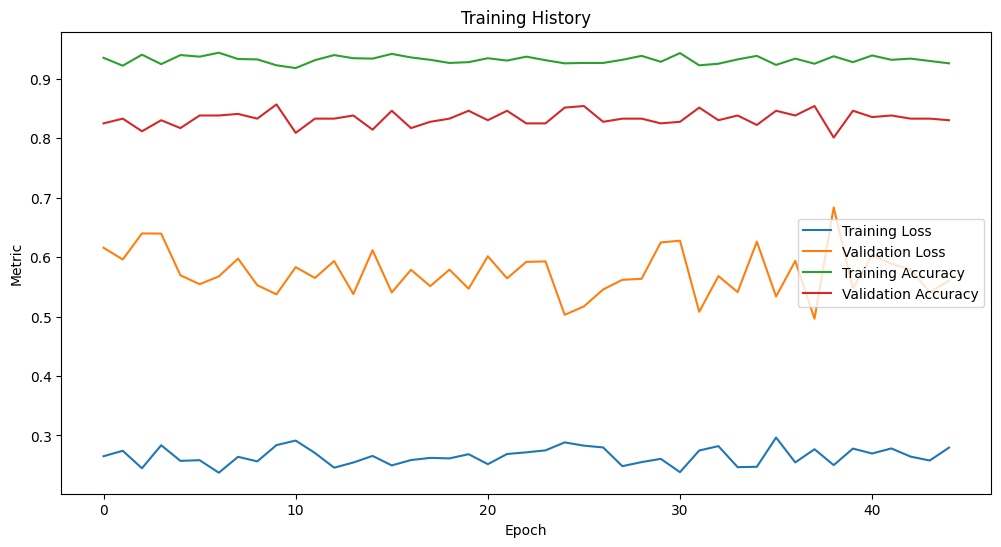

In [18]:
## Training History Plot
plt.figure(figsize=(12, 6))
plt.plot(history_model_customized.history['loss'], label='Training Loss')
plt.plot(history_model_customized.history['val_loss'], label='Validation Loss')
plt.plot(history_model_customized.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_customized.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training History')
plt.legend()
plt.show()

### Pretrained Model

In [19]:
model_pretrained.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])

for i in range(num_subsets):
    history_model_pretrained = model_pretrained.fit(
        train_generators_pretrained[i],
        validation_data=val_generators_pretrained[i],
        epochs=1000,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ]
    )

Epoch 1/1000
95/95 [==============================] - 4s 28ms/step - loss: 0.8589 - accuracy: 0.7302 - val_loss: 0.3784 - val_accuracy: 0.8886
Epoch 2/1000
95/95 [==============================] - 2s 20ms/step - loss: 0.2606 - accuracy: 0.9180 - val_loss: 0.2725 - val_accuracy: 0.8966
Epoch 3/1000
95/95 [==============================] - 2s 21ms/step - loss: 0.1453 - accuracy: 0.9570 - val_loss: 0.2338 - val_accuracy: 0.9178
Epoch 4/1000
95/95 [==============================] - 2s 21ms/step - loss: 0.0810 - accuracy: 0.9821 - val_loss: 0.1925 - val_accuracy: 0.9284
Epoch 5/1000
95/95 [==============================] - 2s 20ms/step - loss: 0.0669 - accuracy: 0.9795 - val_loss: 0.2434 - val_accuracy: 0.9204
Epoch 6/1000
95/95 [==============================] - 2s 20ms/step - loss: 0.0252 - accuracy: 0.9967 - val_loss: 0.1616 - val_accuracy: 0.9469
Epoch 7/1000
95/95 [==============================] - 2s 21ms/step - loss: 0.0157 - accuracy: 0.9987 - val_loss: 0.1460 - val_accuracy: 0.9496

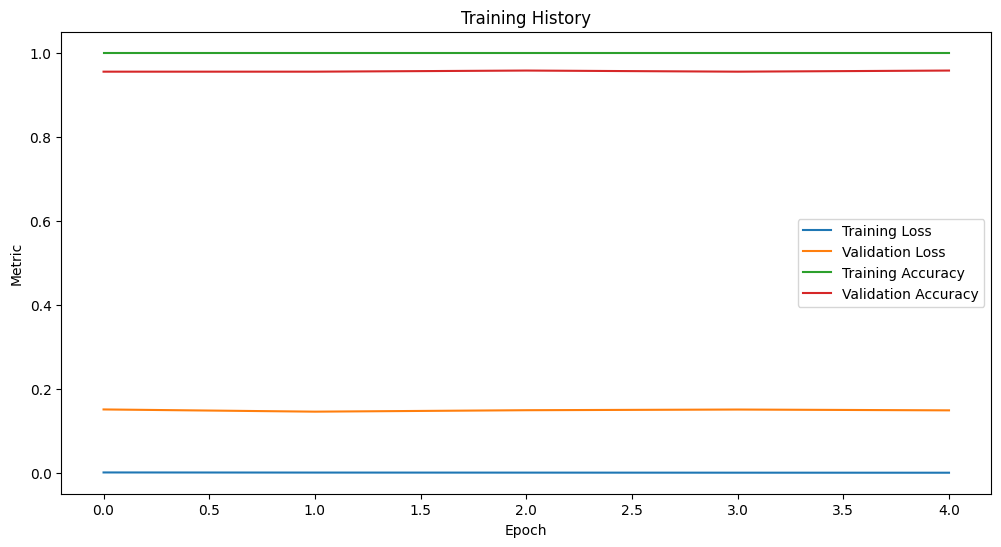

In [20]:
## Training History Plot
plt.figure(figsize=(12, 6))
plt.plot(history_model_pretrained.history['loss'], label='Training Loss')
plt.plot(history_model_pretrained.history['val_loss'], label='Validation Loss')
plt.plot(history_model_pretrained.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training History')
plt.legend()
plt.show()

# Evaluation

### Customized Model

In [21]:
customized_results = model_customized.evaluate(test_images)
print("Test Accuracy: {:.2f}%".format(customized_results[1] * 100))

26/26 [==============================] - 1s 40ms/step - loss: 0.4971 - accuracy: 0.8520
Test Accuracy: 85.20%


In [22]:
predictions_customized = model_customized.predict(test_images)
predicted_labels_customized = np.argmax(predictions_customized, axis=1)

cm_customized = confusion_matrix(test_images.labels, predicted_labels_customized)
clr_customized = classification_report(test_images.labels, predicted_labels_customized, target_names=test_images.class_indices)

26/26 [==============================] - 1s 31ms/step


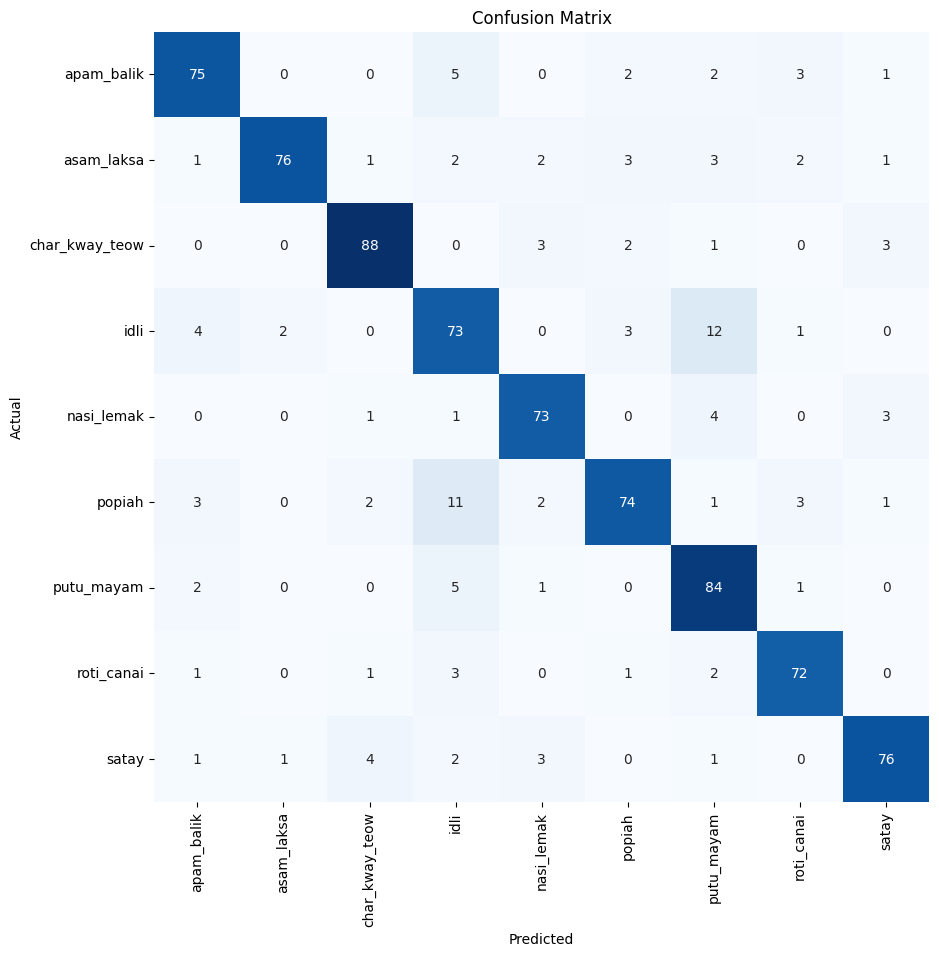

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm_customized, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels = test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels = test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [24]:
print("Customized Classification Report:\n--------------------\n", clr_customized)

Customized Classification Report:
--------------------
                 precision    recall  f1-score   support

    apam_balik       0.86      0.85      0.86        88
    asam_laksa       0.96      0.84      0.89        91
char_kway_teow       0.91      0.91      0.91        97
          idli       0.72      0.77      0.74        95
    nasi_lemak       0.87      0.89      0.88        82
        popiah       0.87      0.76      0.81        97
    putu_mayam       0.76      0.90      0.83        93
    roti_canai       0.88      0.90      0.89        80
         satay       0.89      0.86      0.88        88

      accuracy                           0.85       811
     macro avg       0.86      0.85      0.85       811
  weighted avg       0.86      0.85      0.85       811



### Pretrained Model

In [25]:
pretrained_results = model_pretrained.evaluate(test_images)
print("Test Accuracy: {:.2f}%".format(pretrained_results[1] * 100))

26/26 [==============================] - 1s 32ms/step - loss: 0.1827 - accuracy: 0.9544
Test Accuracy: 95.44%


In [26]:
predictions_pretrained = model_pretrained.predict(test_images)
predicted_labels_pretrained = np.argmax(predictions_pretrained, axis=1)

cm_pretrained = confusion_matrix(test_images.labels, predicted_labels_pretrained)
clr_pretrained = classification_report(test_images.labels, predicted_labels_pretrained, target_names=test_images.class_indices)

26/26 [==============================] - 1s 33ms/step


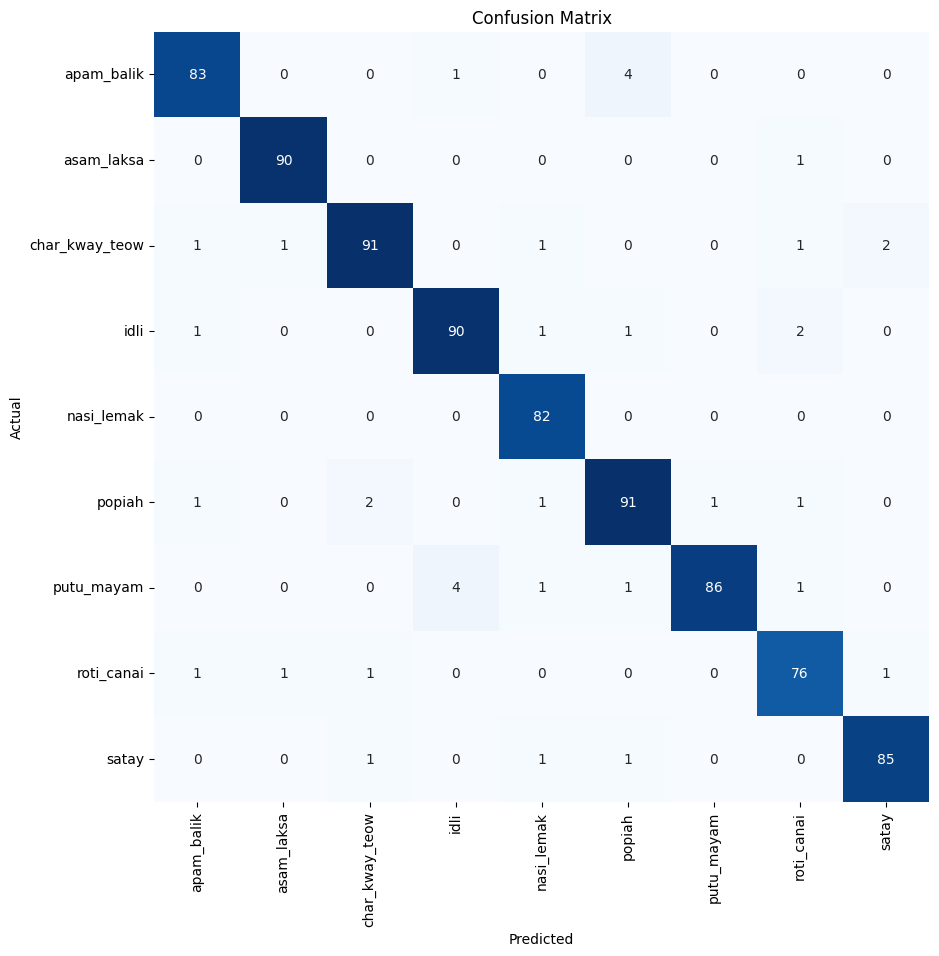

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm_pretrained, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels = test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels = test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
print("Pretrained Classification Report:\n--------------------\n", clr_pretrained)

Pretrained Classification Report:
--------------------
                 precision    recall  f1-score   support

    apam_balik       0.95      0.94      0.95        88
    asam_laksa       0.98      0.99      0.98        91
char_kway_teow       0.96      0.94      0.95        97
          idli       0.95      0.95      0.95        95
    nasi_lemak       0.94      1.00      0.97        82
        popiah       0.93      0.94      0.93        97
    putu_mayam       0.99      0.92      0.96        93
    roti_canai       0.93      0.95      0.94        80
         satay       0.97      0.97      0.97        88

      accuracy                           0.95       811
     macro avg       0.95      0.96      0.95       811
  weighted avg       0.95      0.95      0.95       811



### Ensemble Method

In [29]:
# Perform averaging
ensemble_predictions = (predictions_customized + predictions_pretrained) / 2

# Determine final prediction
final_predictions = np.argmax(ensemble_predictions, axis=1)

cm_ensemble = confusion_matrix(test_images.labels, final_predictions)
clr_ensemble = classification_report(test_images.labels, final_predictions, target_names=test_images.class_indices)

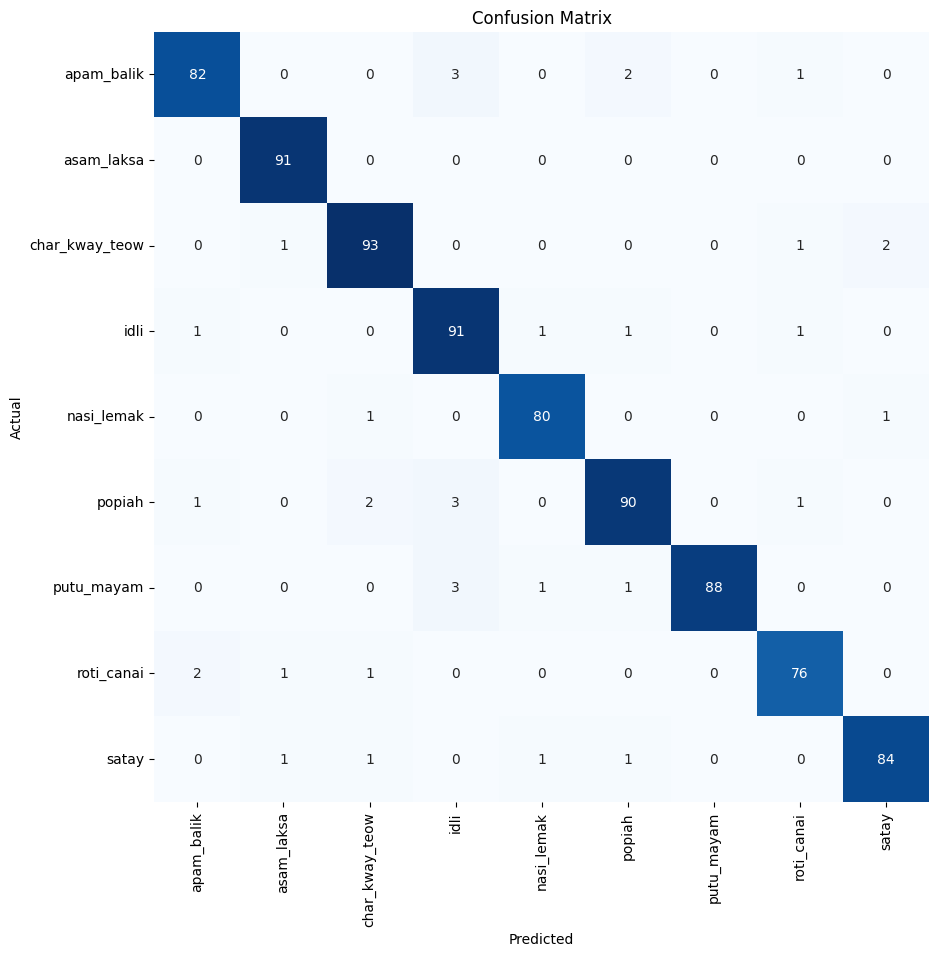

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm_ensemble, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels = test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels = test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [31]:
print("Ensemble Classification Report:\n--------------------\n", clr_ensemble)

Ensemble Classification Report:
--------------------
                 precision    recall  f1-score   support

    apam_balik       0.95      0.93      0.94        88
    asam_laksa       0.97      1.00      0.98        91
char_kway_teow       0.95      0.96      0.95        97
          idli       0.91      0.96      0.93        95
    nasi_lemak       0.96      0.98      0.97        82
        popiah       0.95      0.93      0.94        97
    putu_mayam       1.00      0.95      0.97        93
    roti_canai       0.95      0.95      0.95        80
         satay       0.97      0.95      0.96        88

      accuracy                           0.96       811
     macro avg       0.96      0.96      0.96       811
  weighted avg       0.96      0.96      0.96       811



# Save Model

In [32]:
# Save Customized Model
tf.saved_model.save(model_customized, 'foodvision_model_customized')

MODEL_DIR = r"C:\Users\SIA_RTX3070\Desktop"
export_path = os.path.join(MODEL_DIR, "foodvision_model_customized")
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model_customized,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: foodvision_model_customized\assets


INFO:tensorflow:Assets written to: foodvision_model_customized\assets


export_path = C:\Users\SIA_RTX3070\Desktop\foodvision_model_customized



INFO:tensorflow:Assets written to: C:\Users\SIA_RTX3070\Desktop\foodvision_model_customized\assets


INFO:tensorflow:Assets written to: C:\Users\SIA_RTX3070\Desktop\foodvision_model_customized\assets



Saved model:


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
# Save Pretrained Model
tf.saved_model.save(model_pretrained, 'foodvision_model_pretrained')

MODEL_DIR = r"C:\Users\SIA_RTX3070\Desktop"
export_path = os.path.join(MODEL_DIR, "foodvision_model_pretrained")
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model_pretrained,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: foodvision_model_pretrained\assets


INFO:tensorflow:Assets written to: foodvision_model_pretrained\assets


export_path = C:\Users\SIA_RTX3070\Desktop\foodvision_model_pretrained



INFO:tensorflow:Assets written to: C:\Users\SIA_RTX3070\Desktop\foodvision_model_pretrained\assets


INFO:tensorflow:Assets written to: C:\Users\SIA_RTX3070\Desktop\foodvision_model_pretrained\assets



Saved model:


'ls' is not recognized as an internal or external command,
operable program or batch file.
